In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import matplotlib.pyplot as plt # for plotting
import numpy as np # for transformation

import torch # PyTorch package
import torchvision # load datasets
import torchvision.transforms as transforms # transform data
import torch.nn as nn # basic building block for neural neteorks
import torch.nn.functional as F # import convolution functions like Relu
import torch.optim as optim # optimzer

In [2]:
transform = transforms.Compose( # composing several transforms together
    [transforms.ToTensor(), # to tensor object
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # mean = 0.5, std = 0.5

# set batch_size
batch_size = 4

# set number of workers
num_workers = 2

# load train data
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=num_workers)

# load test data
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=num_workers)

# put 10 classes into a set
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:08<00:00, 20811829.94it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


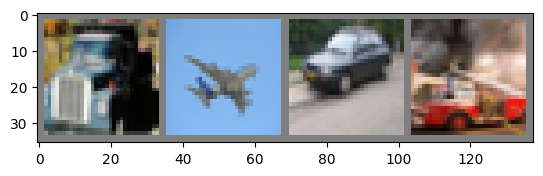

truck plane car truck


In [4]:
def imshow(img):
    ''' function to show image '''
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy() # convert to numpy objects
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get random training images with iter function
dataiter = iter(trainloader)
images, labels = next(iter(dataiter))

# call function on our images
imshow(torchvision.utils.make_grid(images))

# print the class of the image
print(' '.join('%s' % classes[labels[j]] for j in range(batch_size)))

## Defining a CNN architecture

In [5]:
class Net(nn.Module):
    ''' Models a simple Convolutional Neural Network'''
    def __init__(self):
        ''' initialize the network '''
        super(Net, self).__init__()
        # 3 input image channel, 6 output channels, 
        # 5x5 square convolution kernel
        self.conv1 = nn.Conv2d(3, 6, 5)
        # Max pooling over a (2, 2) window
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5) 
        self.fc1 = nn.Linear(16 * 5 * 5, 120)# 5x5 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        ''' the forward propagation algorithm '''
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [7]:
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

start.record()

for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

# whatever you are timing goes here
end.record()

# Waits for everything to finish running
torch.cuda.synchronize()

print('Finished Training')
print(start.elapsed_time(end))  # milliseconds

[1,  2000] loss: 2.152
[1,  4000] loss: 1.859
[1,  6000] loss: 1.709
[1,  8000] loss: 1.623
[1, 10000] loss: 1.528
[1, 12000] loss: 1.481
[2,  2000] loss: 1.402
[2,  4000] loss: 1.405
[2,  6000] loss: 1.369
[2,  8000] loss: 1.349
[2, 10000] loss: 1.315
[2, 12000] loss: 1.263
Finished Training
109094.46875


In [8]:
# save
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)
# reload
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [11]:
outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:  bird plane car car
